In [5]:
import numpy as np
import pandas as pd
import random
import re

In [ ]:
def arcs_to_vector(expression: re.Pattern, lines: list) -> pd.DataFrame:
    filtered = list(filter(expression.match, lines))
    vector = map(lambda x: x.split()[1:], filtered)
    colnames = ("tail", "head", "low", "cap", "cost")
    data = pd.DataFrame.from_records(list(vector), columns=colnames).astype(int)
    data["flow"] = 0
    return data

def special_nodes_to_arc(nodes: pd.DataFrame, value: int, origin=True):
    if origin:
        data = {
            "head": nodes["node"],
            "cap": nodes["flow"],
            "low": nodes["flow"],
        }
        data["tail"] = value
    else:
        data = {
            "tail": nodes["node"],
            "cap": -nodes["flow"],
            "low": -nodes["flow"],
        }
        data["head"] = value
    data["cost"] = 0
    data["flow"] = 0
    return pd.DataFrame(data, columns=("tail", "head", "low", "cap", "cost", "flow"))

def nodes_to_vector(expression: re.Pattern, lines: list) -> pd.DataFrame:
    filtered = list(filter(expression.match, lines))
    vector = map(lambda x: x.split()[1:], filtered)
    nodes = pd.DataFrame.from_records(list(vector), columns=("node", "flow")).astype(int)
    
    source_nodes = nodes["flow"] > 0
    sink_nodes = nodes["flow"] < 0
    
    return pd.concat([
        special_nodes_to_arc(nodes[source_nodes], 25001),
        special_nodes_to_arc(nodes[sink_nodes], 25002, origin=False),
    ])


def read_file(path_to_file: str) -> pd.DataFrame:
    r_arcs = re.compile("^a")
    r_nodes = re.compile("^n")
    with open(path_to_file) as f:
        content = f.readlines()
        arcs =  arcs_to_vector(r_arcs, content)
        nodes = nodes_to_vector(r_nodes, content)
    response = pd.concat([arcs, nodes], ignore_index=True)
    display(response)
    return response

In [ ]:
def select_random(node: int, network: pd.DataFrame, end_network=6) -> pd.Series:
    #out_node = network[(network["tail"] == node) & (network["head"] == end_network)]
    mask_to = (network["tail"] == node) & (network["cap"] > network["flow"])
    if mask_to.sum() > 0:
        selected = random.choice(network[mask_to].index)
        return network.loc[selected]
    return None

def open_pipe(arc: pd.Series, network: pd.DataFrame, flow: int) -> pd.DataFrame:
    if arc["cap"] >= arc["flow"] + flow:
        arc["flow"] = arc["flow"] + flow
        network.iloc[arc.name] = arc

def given_flow(arc: pd.Series, flow_available: int) -> int:
    aux = arc["cap"] - arc["flow"]
    aux_array = np.array(range(1, aux+1))
    aux_array = aux_array[aux_array <= flow_available]
    if len(aux_array) > 0:
        flow = random.choice(aux_array)
    else:
        flow = 0
    return flow

def is_full(in_node: int, network: pd.DataFrame, input_flow: int) -> bool:
    in_node = network[network["tail"] == in_node]
    if in_node["flow"].sum() == input_flow:
        return True
    return False

def change_node(network: pd.DataFrame) -> pd.Series:
    visited = network["tail"][network["flow"] != 0].unique()
    not_visited = network["tail"][network["flow"] == 0].unique()
    not_visited = list(set(not_visited).difference(set(visited)))
    possibles_to = network[network["tail"].isin(visited) & network["head"].isin(not_visited)]
    if len(possibles_to):
        node_selected = random.choice(possibles_to["head"].unique())
    else:
        aux = set(network["tail"]).intersection(set(network["head"]))
        possibles = []
        for i in aux:
            in_flow = network["flow"][network["tail"] == i].sum()
            out_flow = network["flow"][network["head"] == i].sum()
            #display(f"In node {i} {in_flow}->{out_flow}")
            if in_flow != out_flow:
                possibles.append(i)
        if len(possibles) == 0:
            return None, None
        node_selected = random.choice(possibles)
    total_input = network["flow"][network["head"] == node_selected].sum()
    return node_selected, total_input
        
def is_solution(network: pd.DataFrame, start: int, end: int) -> bool:
    in_start = network["flow"][network["tail"] == start].sum()
    in_end = network["flow"][network["head"] == end].sum()
    return in_start == in_end

def compute_total_cost(network: pd.DataFrame) -> int:
    used = network["flow"] > 0
    return (network["cost"] *  used).sum()
    
def run_pipe(start: int, end: int, network: pd.DataFrame, input_flow, output_flow):
    in_node = start
    flow_available = input_flow
    while True:
        go_to = select_random(in_node, network)
        if go_to is not None:
            flow = given_flow(go_to, flow_available)
            #display(f"({i}) {in_node} -({flow})-> {go_to['head']}: {flow_available}/{input_flow}")
            open_pipe(go_to, network, flow)
            flow_available = flow_available - flow
        if is_full(in_node, network, input_flow):
            in_node, input_flow = change_node(network)
            if in_node is None:
                break
            flow_available = input_flow- network["flow"][network["tail"] == in_node].sum()
            #display(f"available: {flow_available} aa {network['flow'][network['tail'] == in_node].sum()}")
            #display(network)
        if go_to is None:
            break
    aux = network["head"].unique()
    for i in aux:
        in_flow = network["flow"][network["head"] == i].sum()
        out_flow = network["flow"][network["tail"] == i].sum()
        cap = network["cap"][network["tail"] == i].sum()
        #display(f"In node {i} {in_flow}->{out_flow} / {cap}")
    return network

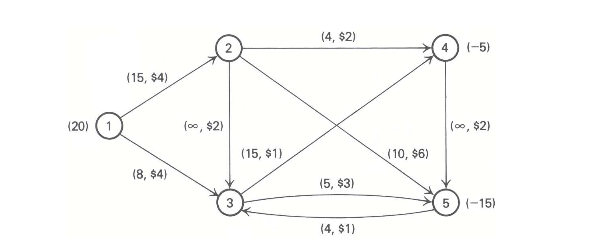

In [ ]:
costs = []
solutioned = False
for i in range(0, 100):
    print(i)
    while not solutioned:
        small = pd.read_csv("../small.csv")
        sol = run_pipe(1, 6, small, 20, -20)
        solutioned = is_solution(sol, 1, 6)
        
        print(solutioned)
        if solutioned:
            cost = compute_total_cost(sol)
            costs.append(cost)
    solutioned = False

In [ ]:
costs

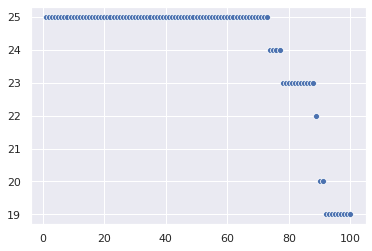

In [15]:
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

ax = sns.scatterplot(x=np.array(range(1, 101)), y=np.array(sorted(costs, reverse=True)))

In [1]:
import pickle

In [ ]:
with open("costs.pkl", "wb") as f:
    pickle.dump(costs, f)

In [7]:
costs = pickle.load(open("costs.pkl", "rb"))

In [14]:
costs.sort()